### project Name- IMDB Movie
### data set-  https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

### Name- RAJ SEKHAR BEHERA
### Reg no- 2201020111
### cranes Reg no- CL202501060194286


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_csv('/content/sentiment_train.csv')

In [ ]:
df.head()

,sentence,label
0,Ok brokeback mountain is such a horrible movie.,0
1,Brokeback Mountain was so awesome.,1
2,friday hung out with kelsie and we went and sa...,0
3,I am going to start reading the Harry Potter s...,1
4,"Is it just me, or does Harry Potter suck?...",0


In [ ]:
df.describe()

,label
count,5668.000000
mean,0.565279
std,0.495764
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


In [ ]:
lens = [len(i.split()) for i in df.sentence]

In [ ]:
import matplotlib.pyplot as plt
plt.hist(lens)

In [42]:
!pip install transformers

In [43]:
#for pytorch
import torch
import torch.nn as nn
device = torch.device("cuda")

#for BERT
import transformers
from transformers import AutoModel, BertTokenizerFast

In [44]:
# split into train, validation and test sets in the ration 70 : 15 : 15
from sklearn.model_selection import train_test_split

train_text, temp_text, train_labels, temp_labels = train_test_split(df['sentence'], df['label'],
                                                                    random_state=2021,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2021,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

In [45]:
# Install nlpaug and nltk if not already installed
!pip install -q nlpaug
!pip install -q nltk

# Import necessary libraries
import nltk
import nlpaug.augmenter.word as naw

# Force fresh download of required NLTK resources
nltk.download('averaged_perceptron_tagger', download_dir='/usr/local/nltk_data')
nltk.download('wordnet', download_dir='/usr/local/nltk_data')
nltk.download('omw-1.4', download_dir='/usr/local/nltk_data')

# Set the nltk data path manually in case the environment doesn't pick it up
nltk.data.path.append('/usr/local/nltk_data')

# Synonym replacement augmentation
aug = naw.SynonymAug(aug_src='wordnet')





[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/local/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/local/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/local/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/local/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/local/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/local/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data]   Package omw-1.4 is already up-to-date!


In [46]:
# import BERT-Large uncased pretrained model
bert = AutoModel.from_pretrained('bert-large-uncased')

In [47]:
# Load the BERT-Large uncased tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-large-uncased')

(array([1504.,  701.,  572.,  521.,  164.,  215.,  117.,   63.,  104.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

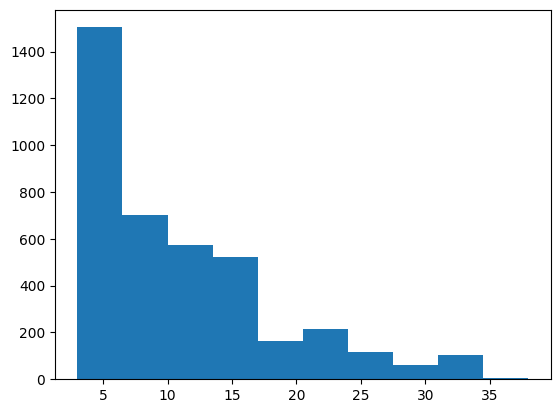

(array([1504.,  701.,  572.,  521.,  164.,  215.,  117.,   63.,  104.,
           6.]),
 array([ 3. ,  6.5, 10. , 13.5, 17. , 20.5, 24. , 27.5, 31. , 34.5, 38. ]),
 <BarContainer object of 10 artists>)

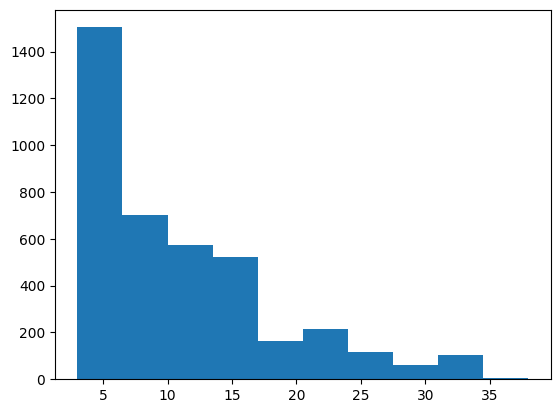

In [48]:
train_lens=[len(i.split()) for i in train_text]
plt.hist(train_lens)

In [49]:
# As per the above graph, as most of the texts are having around 17 words, we would consider 17 as the padding length.

pad_len=17

In [50]:
# tokenize and encode sequences
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = pad_len,
    padding='max_length',
    truncation=True
)

tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = pad_len,
    padding='max_length',
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = pad_len,
    padding='max_length',
    truncation=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 64

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze the BERT architecture

for param in bert.parameters():
    param.requires_grad = True

In [ ]:
# Below, we define the BERT architecture, i.e., define our own layers in addition to the actual BERT architecture

In [ ]:
class BERT_architecture(nn.Module):

    def __init__(self, bert):

      super(BERT_architecture, self).__init__()

      self.bert = bert

      # dropout layer
      self.dropout = nn.Dropout(0.3)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(1024, 512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

In [ ]:
if torch.cuda.is_available():
  print("GPU is available!")
  print(torch.cuda.get_device_name(0))
else:
  print("GPU is not available.")

GPU is available!
Tesla T4


In [57]:
# pass the pre-trained BERT to our define architecture
model = BERT_architecture(bert)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Move your data to the GPU as well (e.g., within your training loop)
for batch in train_dataloader:
  input_ids = batch[0].to(device)
  attention_mask = batch[1].to(device)
  labels = batch[2].to(device)

In [ ]:
# Import AdamW from torch.optim
from torch.optim import AdamW

# Define the optimizer as before
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(train_labels),
                                        y = train_labels
                                     )
print("class weights are {} for {}".format(class_weights,np.unique(train_labels)))

In [ ]:
#count of both the categories of training labels
pd.value_counts(train_labels)

In [ ]:
#wrap class weights in tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push weights to GPU
weights = weights.to(device)

# define loss function
# add weights to handle the "imbalance" in the dataset
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 20

In [ ]:
# function to train the model
def train():

  model.train()

  total_loss, total_accuracy = 0, 0

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(train_dataloader):

    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]

    sent_id, mask, labels = batch

    # clear previously calculated gradients
    model.zero_grad()

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [ ]:
# function for evaluating the model
def evaluate():

  print("\nEvaluating...")

  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0

  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):

    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:

      # # Calculate elapsed time in minutes.
      # elapsed = format_time(time.time() - t0)

      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():

      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader)

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [31]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, _ = train()

    #evaluate model
    valid_loss, _ = evaluate()

    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print('\nTraining Loss: {}'.format(train_loss))
    print('Validation Loss: {}'.format(valid_loss))


 Epoch 1 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.4269182387619249
Validation Loss: 0.09979221916624478

 Epoch 2 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.0579109501183754
Validation Loss: 0.04943311720022133

 Epoch 3 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.019649699458011215
Validation Loss: 0.0411880865160908

 Epoch 4 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.007589887542229506
Validation Loss: 0.036831408082174937

 Epoch 5 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.004226436250798044
Validation Loss: 0.03947545789248709

 Epoch 6 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.002492222502159195
Validation Loss: 0.03780633633557175

 Epoch 7 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.0012567344763796896
Validation Loss: 0.038441637730492015

 Epoch 8 / 20
  Batch    50  of     62.

Evaluating...

Training Loss: 0.000821845586253931

In [32]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

<All keys matched successfully>

In [33]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report

In [64]:
pred = np.argmax(preds, axis = 1)
print(classification_report(test_y, pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99       370
           1       1.00      0.98      0.99       481

    accuracy                           0.99       851
   macro avg       0.99      0.99      0.99       851
weighted avg       0.99      0.99      0.99       851

